# SIFT Matching

Done By: 210236P Jayakumar W.S.

Instructed by: Dr. R. Rodrigo

In this notebook, we try to find the location of a cereal box, given a template in a store shelf full of many other cereal boxes. We use the SIFT algorithm to find the location of the template in the image.

### Import Necessary Modules

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Read images and visualize

In [2]:
ASSET_PATH = Path('images')
OAT_TEMPLATE = ASSET_PATH / 'oat_crunch.jpg'
CORN_TEMPLATE = ASSET_PATH / 'corn_chex.jpg'
STORE_SHELF = ASSET_PATH / 'store_shelf.png'

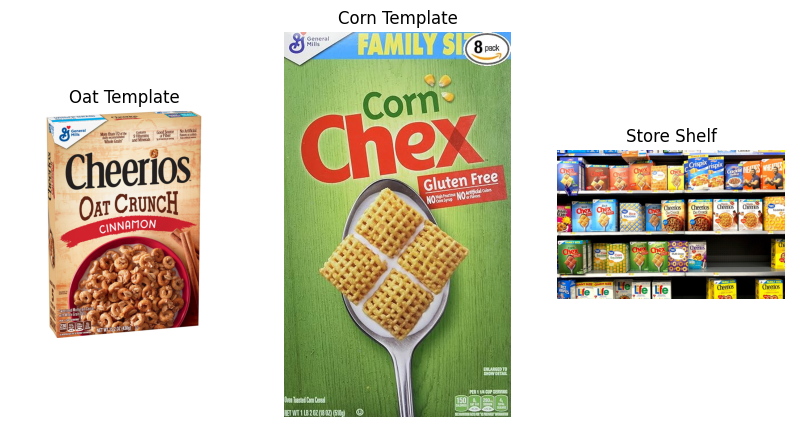

In [3]:
# Load the template and the image
oat_template = cv2.imread(OAT_TEMPLATE, cv2.IMREAD_COLOR)
corn_template = cv2.imread(CORN_TEMPLATE, cv2.IMREAD_COLOR)
store_image = cv2.imread(STORE_SHELF, cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(oat_template, cv2.COLOR_BGR2RGB))
ax[0].set_title('Oat Template')
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(corn_template, cv2.COLOR_BGR2RGB))
ax[1].set_title('Corn Template')
ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(store_image, cv2.COLOR_BGR2RGB))
ax[2].set_title('Store Shelf')
ax[2].axis('off')
plt.show()

### Create SIFT Object

We create a SIFT object and detect keypoints and descriptors for the template and the image. Keypoints are points in an image invariant to scale, rotation, and translation. Descriptors are vectors that describe the keypoints.

In [4]:
sift = cv2.SIFT_create()
kp_oat, des_oat = sift.detectAndCompute(oat_template, None)
kp_corn, des_corn = sift.detectAndCompute(corn_template, None)
kp_store, des_store = sift.detectAndCompute(store_image, None)

In [5]:
kp1 = np.array([kp.pt for kp in kp_oat])
print(kp1)

[[ 410.02017212  696.38232422]
 [ 410.77328491   87.98897552]
 [ 414.27844238   82.94616699]
 ...
 [2145.29467773   75.67662811]
 [2145.4309082    80.90691376]
 [2147.50732422   78.08052063]]


In [6]:
print(des_oat.shape)

(26173, 128)


Keypoints is an array of keypoint objects, where each keypoint object has the following attributes:
- `pt`: (x, y) coordinates of the keypoint
- `size`: diameter of the meaningful keypoint neighborhood  
- `angle`: orientation of the keypoint
- `response`: the response by which the most strong keypoints have been selected
- `octave`: pyramid layer which the keypoint was detected
- `class_id`: object id

Descriptions contains the vectors that describe the keypoints. It is an array of shape (number_of_keypoints, 128).

In [7]:
print(f'Number of keypoints in oat template: {len(kp_oat)}')
print(f'Number of keypoints in corn template: {len(kp_corn)}')
print(f'Number of keypoints in store shelf: {len(kp_store)}')

Number of keypoints in oat template: 26173
Number of keypoints in corn template: 1484
Number of keypoints in store shelf: 8557


### Match Descriptors

Here, we use the FLANN (Fast Library for Approximate Nearest Neighbors) matcher to match the descriptors of the template and the image.

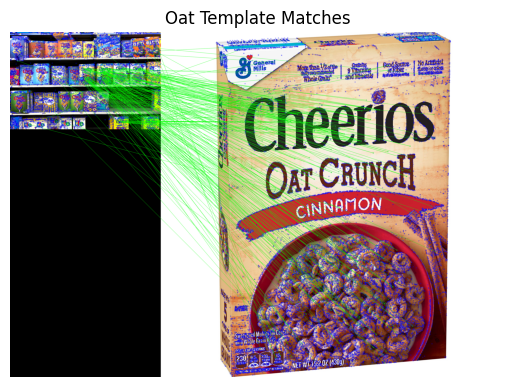

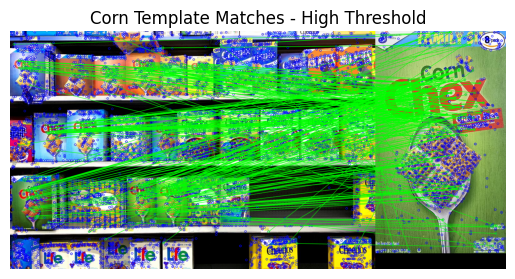

In [8]:
FLANN_INDEX_KDTREE = 1 # Fast Library for Approximate Nearest Neighbors
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_oat = flann.knnMatch(des_store, des_oat, k=2)
matches_corn = flann.knnMatch(des_store, des_corn, k=2)

MATCHESMask = [[0, 0] for i in range(len(matches_oat))]
for i, (m, n) in enumerate(matches_oat):
    if m.distance < 0.7 * n.distance:
        MATCHESMask[i] = [1, 0]
    
draw_params = dict(matchColor=(0, 255, 0),
                     singlePointColor=(255, 0, 0),
                     matchesMask=MATCHESMask,
                     flags=cv2.DrawMatchesFlags_DEFAULT)

oat_result = cv2.drawMatchesKnn(store_image, kp_store, oat_template, kp_oat, matches_oat, None, **draw_params)
plt.imshow(cv2.cvtColor(oat_result, cv2.COLOR_BGR2RGB))
plt.title('Oat Template Matches')
plt.axis('off')
plt.show()


MATCHESMask = [[0, 0] for i in range(len(matches_corn))]
for i, (m, n) in enumerate(matches_corn):
    if m.distance < 0.7 * n.distance:
        MATCHESMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                        singlePointColor=(255, 0, 0),
                        matchesMask=MATCHESMask,
                        flags=cv2.DrawMatchesFlags_DEFAULT)

corn_result = cv2.drawMatchesKnn(store_image, kp_store, corn_template, kp_corn, matches_corn, None, **draw_params)
plt.imshow(cv2.cvtColor(corn_result, cv2.COLOR_BGR2RGB))
plt.title('Corn Template Matches - High Threshold')
plt.axis('off')
plt.show()

Above, it seems that the corn matcher is not wroking as well as the oat matcher. This is due to the fact that other flavours of the same cereal box are present and hence the matching is matching with these as well. Reducing the threshold for the corn matcher will help in getting better results.

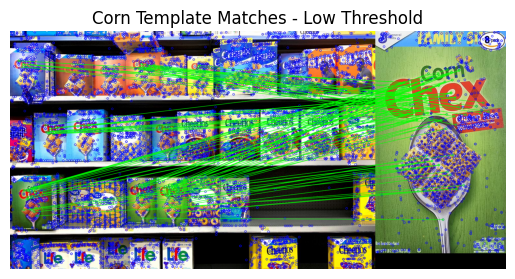

In [9]:
MATCHESMask = [[0, 0] for i in range(len(matches_corn))]
for i, (m, n) in enumerate(matches_corn):
    if m.distance < 0.45 * n.distance:
        MATCHESMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                        singlePointColor=(255, 0, 0),
                        matchesMask=MATCHESMask,
                        flags=cv2.DrawMatchesFlags_DEFAULT)

corn_result = cv2.drawMatchesKnn(store_image, kp_store, corn_template, kp_corn, matches_corn, None, **draw_params)
plt.imshow(cv2.cvtColor(corn_result, cv2.COLOR_BGR2RGB))
plt.title('Corn Template Matches - Low Threshold')
plt.axis('off')
plt.show()

### Finding the location of a book based on the cover

In this section, we redo the above process for a book cover. We will use the book cover as the template and the image of the book as the image.

In [10]:
BOOK_TEMPLATE = ASSET_PATH / 'bookcover.jpg'
ACTUAL_BOOK = ASSET_PATH / 'book.jpg'

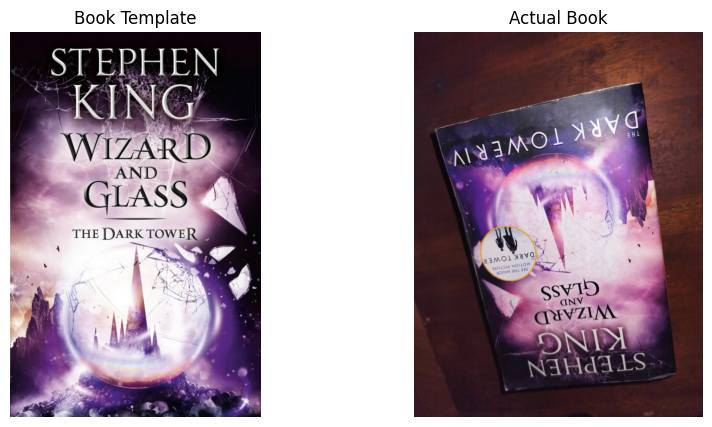

In [16]:
# Load the template and the image
book_cover = cv2.imread(BOOK_TEMPLATE, cv2.IMREAD_COLOR)
book_picture = cv2.imread(ACTUAL_BOOK, cv2.IMREAD_COLOR)
book_picture = cv2.resize(book_picture, (900, 1200)) # Resize the image to be close to the template. It is not
# ncessary to match exactly, but for the sake of visualization while plotting, we will resize it.
book_picture = cv2.flip(book_picture, -1) # Flip the image vertically to test the robustness of the algorithm

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(book_cover, cv2.COLOR_BGR2RGB))
ax[0].set_title('Book Template')
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(book_picture, cv2.COLOR_BGR2RGB))
ax[1].set_title('Actual Book')
ax[1].axis('off')
plt.show()

In [17]:
kp_cover, des_cover = sift.detectAndCompute(book_cover, None)
kp_book, des_book = sift.detectAndCompute(book_picture, None)

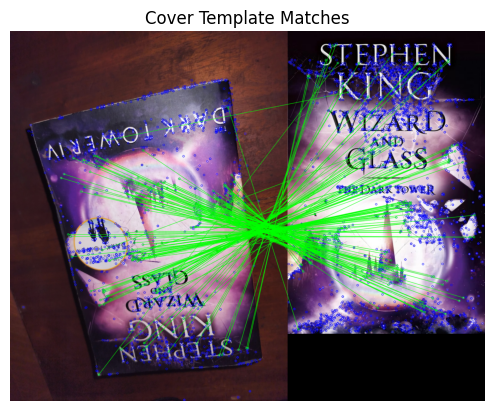

In [18]:
FLANN_INDEX_KDTREE = 1 # Fast Library for Approximate Nearest Neighbors
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_cover = flann.knnMatch(des_book, des_cover, k=2)

MATCHESMask = [[0, 0] for i in range(len(matches_cover))]
for i, (m, n) in enumerate(matches_cover):
    if m.distance < 0.65 * n.distance:
        MATCHESMask[i] = [1, 0]
    
draw_params = dict(matchColor=(0, 255, 0),
                     singlePointColor=(255, 0, 0),
                     matchesMask=MATCHESMask,
                     flags=cv2.DrawMatchesFlags_DEFAULT)

tower_result = cv2.drawMatchesKnn(book_picture, kp_book, book_cover, kp_cover, matches_cover, None, **draw_params)
plt.imshow(cv2.cvtColor(tower_result, cv2.COLOR_BGR2RGB))
plt.title('Cover Template Matches')
plt.axis('off')
plt.show()


It is seen above that for distinct areas such as the letters, the matching is better. We additionally see the robustmess of the algorithm as it is able to match the book cover even when it is flipped vertically.